In [48]:
# importar bibliotecas
from google.cloud import bigquery
from google.oauth2 import service_account
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import pandas as pd
import numpy as np
import seaborn as sns
import warnings

In [49]:
# Realizar conexão com o GCP
credentials = service_account.Credentials.from_service_account_file("../keys/ml-na-saude-ed1fc3c1a83e.json")
client = bigquery.Client(credentials=credentials, project=credentials.project_id)

In [ ]:
consulta_sql = """
with yll_quadrimestral as (
	select
		case
			when extract(month from y.dt_obito) between 1 and 4 then date(extract(year from y.dt_obito), 4, 30)
			when extract(month from y.dt_obito) between 5 and 8 then date(extract(year from y.dt_obito), 8, 31)
			when extract(month from y.dt_obito) between 9 and 12 then date(extract(year from y.dt_obito), 12, 31)
			end as quadrimestre,
		m.nm_municipio,
		p.populacao,
		y.yll / p.populacao * 1000 as taxa_yll
	from `ml-na-saude.yll_por_obito.yll` y
	join `ml-na-saude.yll_por_obito.populacao` p on y.cd_mun_res = p.cd_municipio and y.ano_obito = p.ano
	join `ml-na-saude.yll_por_obito.municipio` m on p.cd_municipio = m.cd_municipio
	where p.porte = 'Médio Porte'
)
select
	quadrimestre,
	avg(taxa_yll) as taxa_media_yll
from yll_quadrimestral
group by quadrimestre
order by quadrimestre
"""

In [51]:
warnings.simplefilter("ignore")
df = client.query(consulta_sql).to_dataframe()

In [52]:
df

,quadrimestre,taxa_media_yll
0,2010-04-30,0.320693
1,2010-08-31,0.315388
2,2010-12-31,0.313191
3,2011-04-30,0.307777
4,2011-08-31,0.305335
5,2011-12-31,0.305019
6,2012-04-30,0.304178
7,2012-08-31,0.304277
8,2012-12-31,0.301382
9,2013-04-30,0.302295


In [53]:
df_tratado = df

In [54]:
df_tratado['quadrimestre'] = pd.to_datetime(df_tratado['quadrimestre'])

In [55]:
df_tratado = df_tratado.set_index('quadrimestre')

In [56]:
time_series = df_tratado

Text(0.5, 1.0, 'Taxa do YLL')

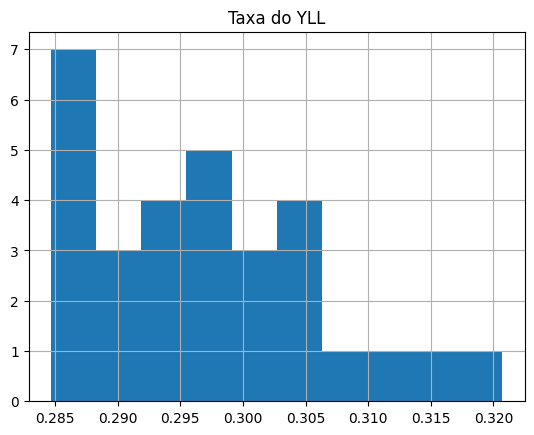

In [57]:
time_series.hist()
plt.title('Taxa do YLL')

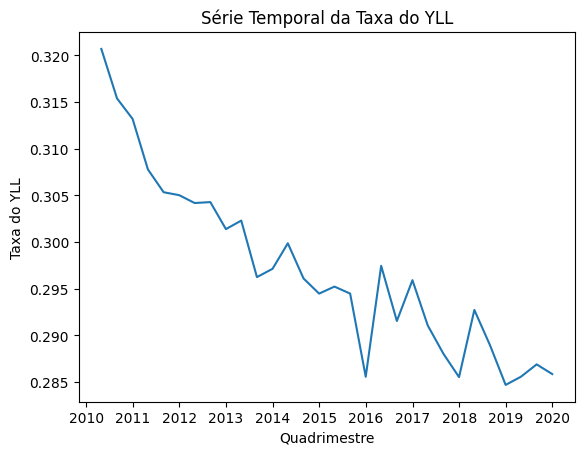

In [58]:
plt.plot(time_series)
plt.title('Série Temporal da Taxa do YLL')
plt.xlabel('Quadrimestre')
plt.ylabel('Taxa do YLL')
plt.show()

In [59]:
# # Configura o eixo x como quadrimestre_obto e o eixo y como taxa_yll
# plt.plot(df['quadrimestre'], df['taxa_yll'], marker='o')
# plt.title('Taxa do YLL por Quadrimestre')
# plt.xlabel('Quadrimestre')
# plt.ylabel('Taxa do YLL')
# plt.xticks(rotation=45)  # Rotaciona os rótulos do eixo x para melhor visualização
# plt.tight_layout()  # Ajusta o layout para evitar sobreposição
# plt.show()

In [60]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(time_series, model='aditive')

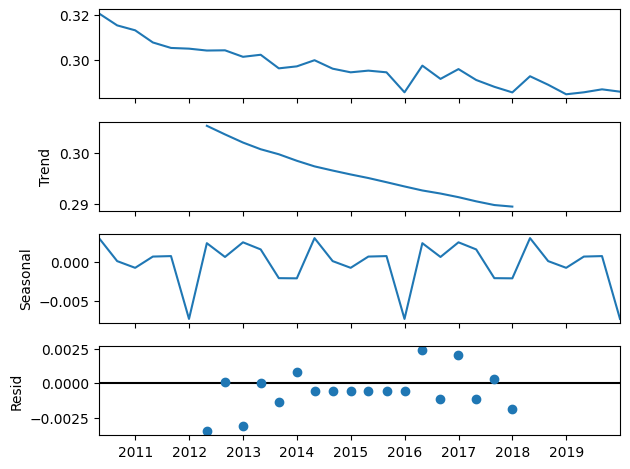

In [61]:
result.plot()
plt.show()

In [62]:
from statsmodels.tsa.stattools import adfuller

### Teste de Estacionaridade

In [63]:
def teste_adf(serie):
    result = adfuller(serie)
    print('ADF Estatíticas: %f' % result[0])
    print('Valor de P: %f' % result[1])
    print('Valores Críticos:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if result[1] < 0.05:
        print("A série é estacionária.")
    else:
        print("A série não é estacionária.")

In [64]:
# Executa o teste de estacionaridade em 'taxa_yll'
teste_adf(time_series['taxa_yll'])

KeyError: 'taxa_yll'

### Tornando a série estacionária (Diferenciação)

In [85]:
# Diferenciação simples
time_series['taxa_yll_diff'] = time_series['taxa_yll'].diff().dropna()

# Verifica novamente a estacionaridade após a diferenciação
teste_adf(time_series['taxa_yll_diff'].dropna())

ADF Estatíticas: -3.938173
Valor de P: 0.001771
Valores Críticos:
	1%: -3.738
	5%: -2.992
	10%: -2.636
A série é estacionária.


<Axes: xlabel='quadrimestre'>

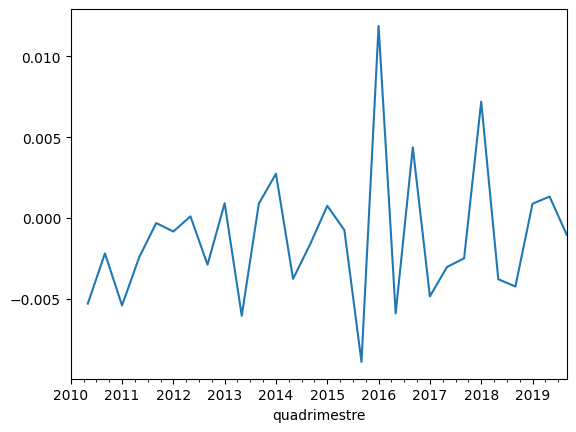

In [86]:
xlabel='Data'
time_series['taxa_yll_diff'].plot()

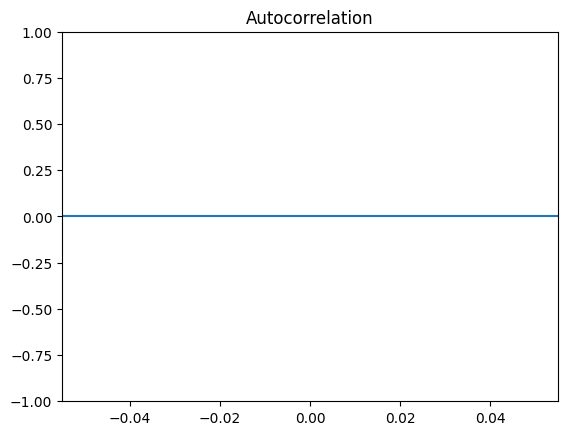

In [88]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(time_series['taxa_yll_diff'])
plt.show()